# No U Turn MCMC

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotnine import *

import pints
import pints.plot
import pints.toy
import pints.cptests.no_u_turn_mcmc as nuts

from utils import run_replicates, ecdf_norm_plotter

parallel = True

# Two dimensional Gaussian

In [2]:
t = pints.Timer()
test = run_replicates(np.geomspace(1000, 5000, 8), 10, nuts.two_dim_gaussian, parallel)
print(t.format())

df = pd.melt(test, id_vars=['iterations', 'replicate'])
#df.to_csv("experimental_data/no_u_turn_2d_gaussian.csv")

48.01 seconds


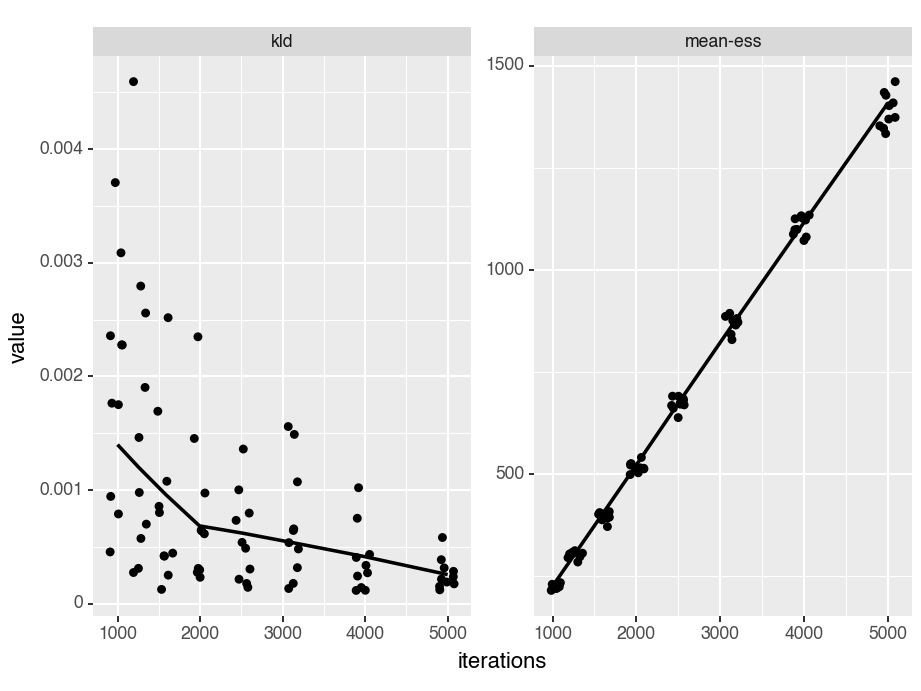

<Figure Size: (460 x 345)>

In [3]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
)

The ESS and KLD both trend in the correct directions.

Show example run results.

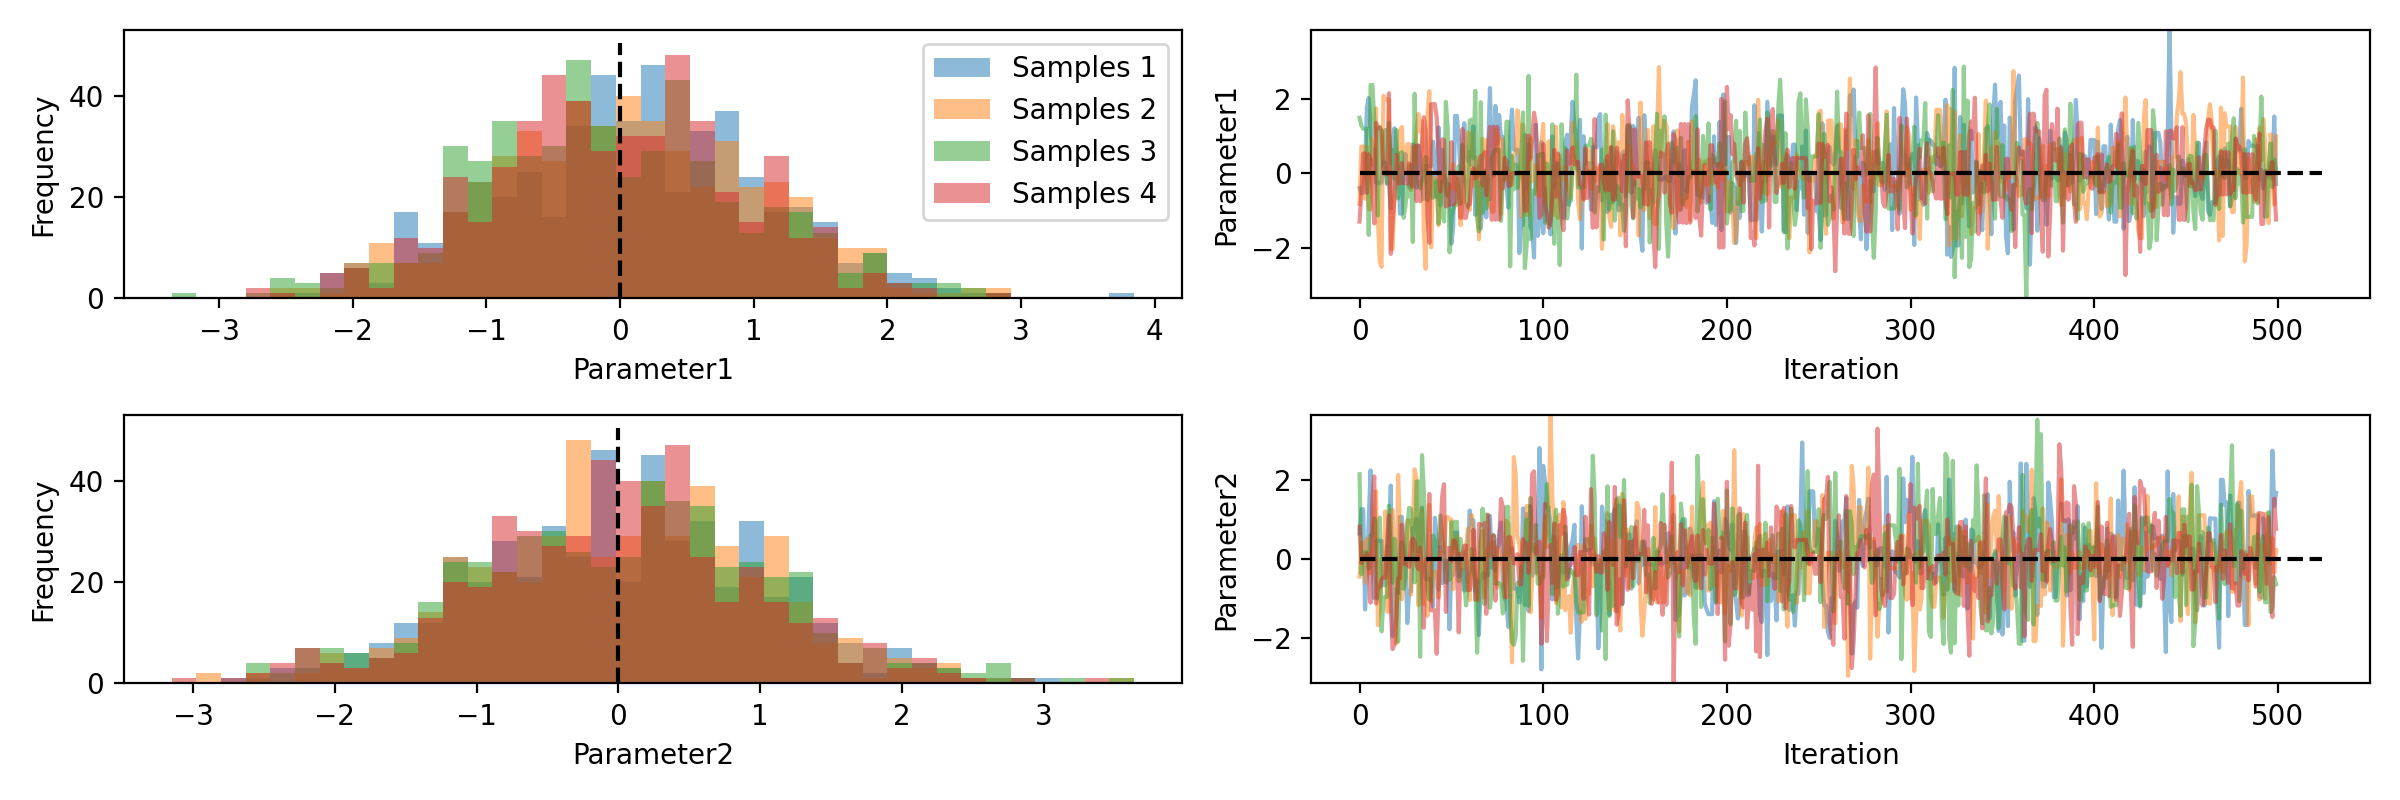

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  0.01    0.99    -1.93   -0.68  -0.01  0.69   1.97     1.00    629.86  734.03
param 2  0.01    1.00    -2.04   -0.67  0.05   0.66   2.01     1.00    622.70  725.69


In [4]:
n_chains = 4
n_iterations = 1000
n_warmup = 500
log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])

# Get initial parameters
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=10),
    pints.GaussianLogPrior(mean=0, sd=10))
x0 = log_prior.sample(n=n_chains)
controller = pints.MCMCController(
            log_pdf, n_chains, x0, method=pints.NoUTurnMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.trace(chains, ref_parameters=[0, 0])

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

The parameters are close to their true means. How do they compare to MCMC eCDFs compare with the theoretical? Look pretty good.

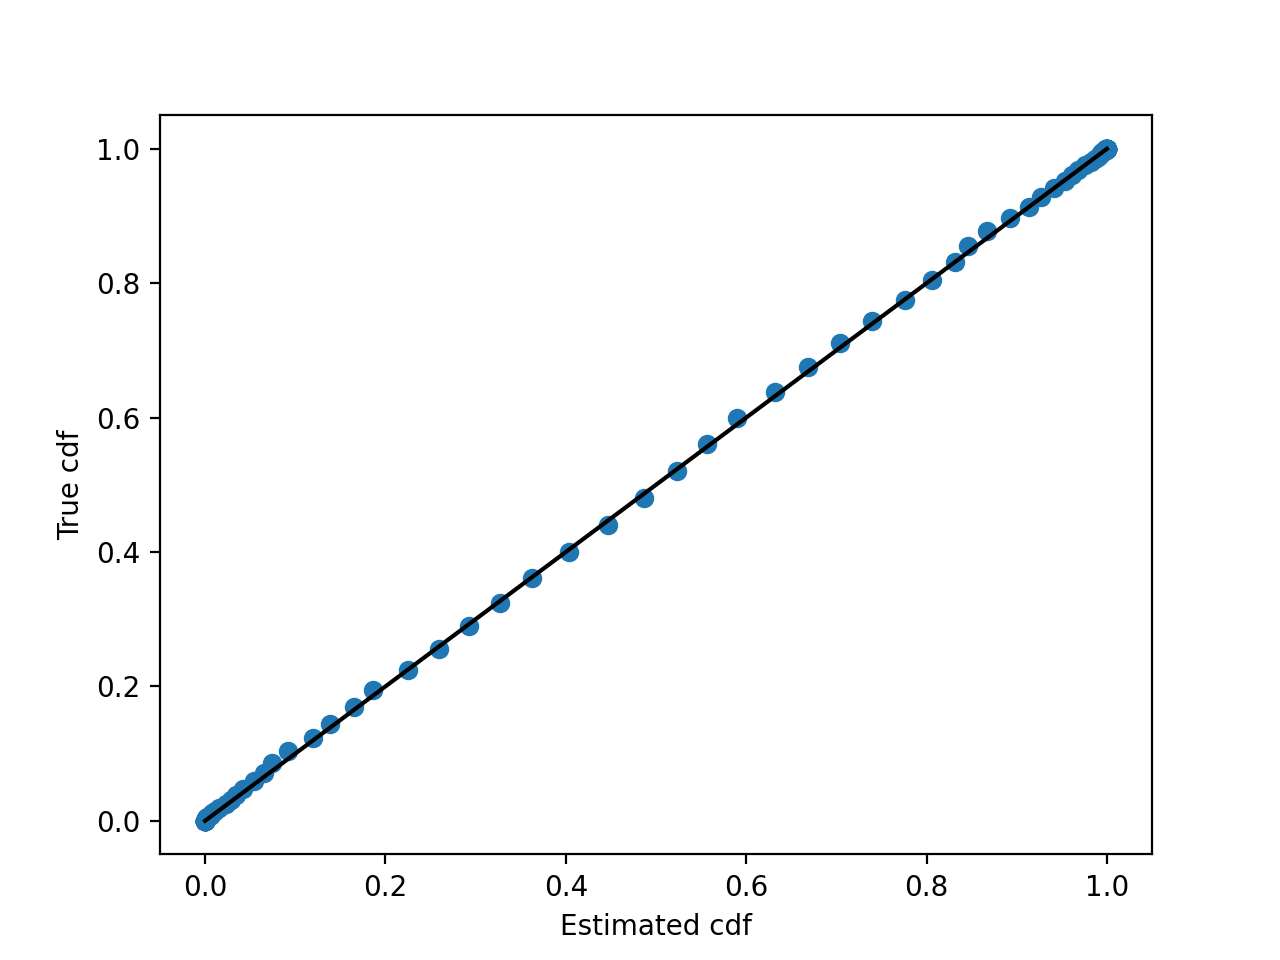

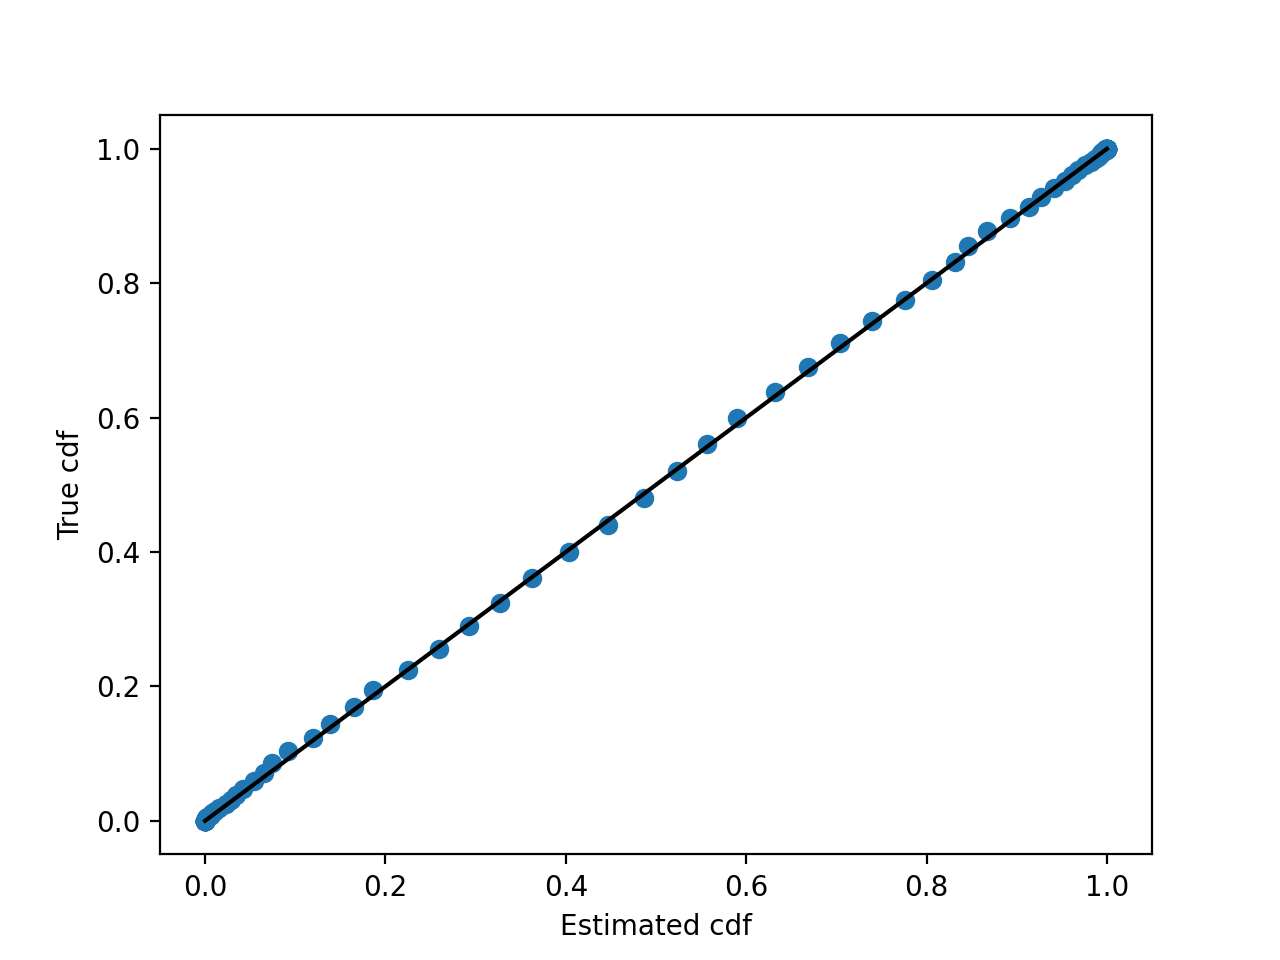

In [5]:
draws = np.vstack(chains)
for _ in range(2):
    ecdf_norm_plotter(draws[:, 0], np.sqrt(1))

# Correlated Gaussian

In [6]:
t = pints.Timer()
test = run_replicates(np.geomspace(1000, 5000, 8), 10, nuts.correlated_gaussian, parallel)
print(t.format())
df = pd.melt(test, id_vars=['iterations', 'replicate'])
#df.to_csv("experimental_data/no_u_turn_correlated_gaussian.csv")

1 minute, 58 seconds


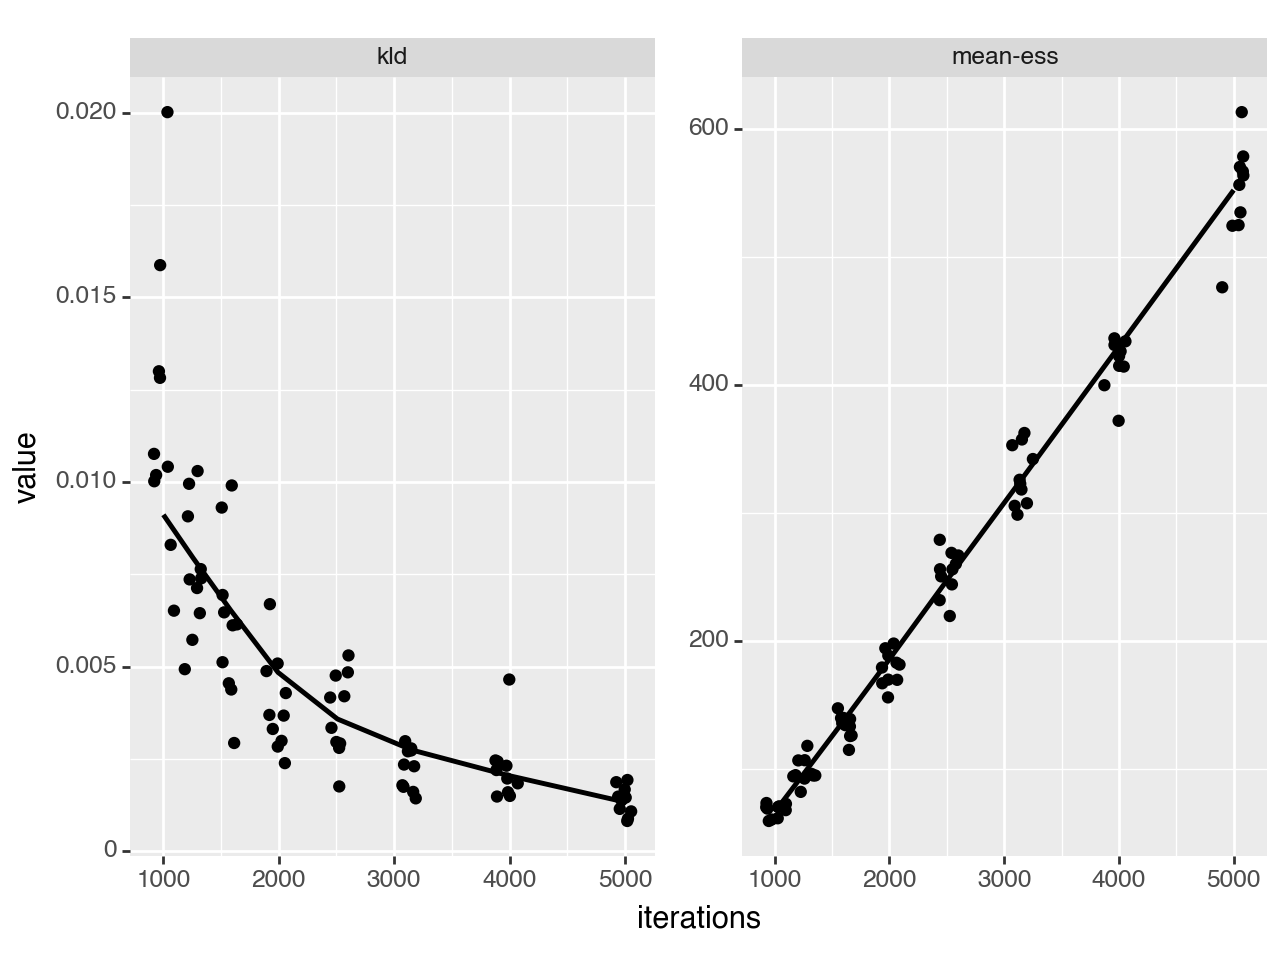

<Figure Size: (640 x 480)>

In [7]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
)

Example run of results.

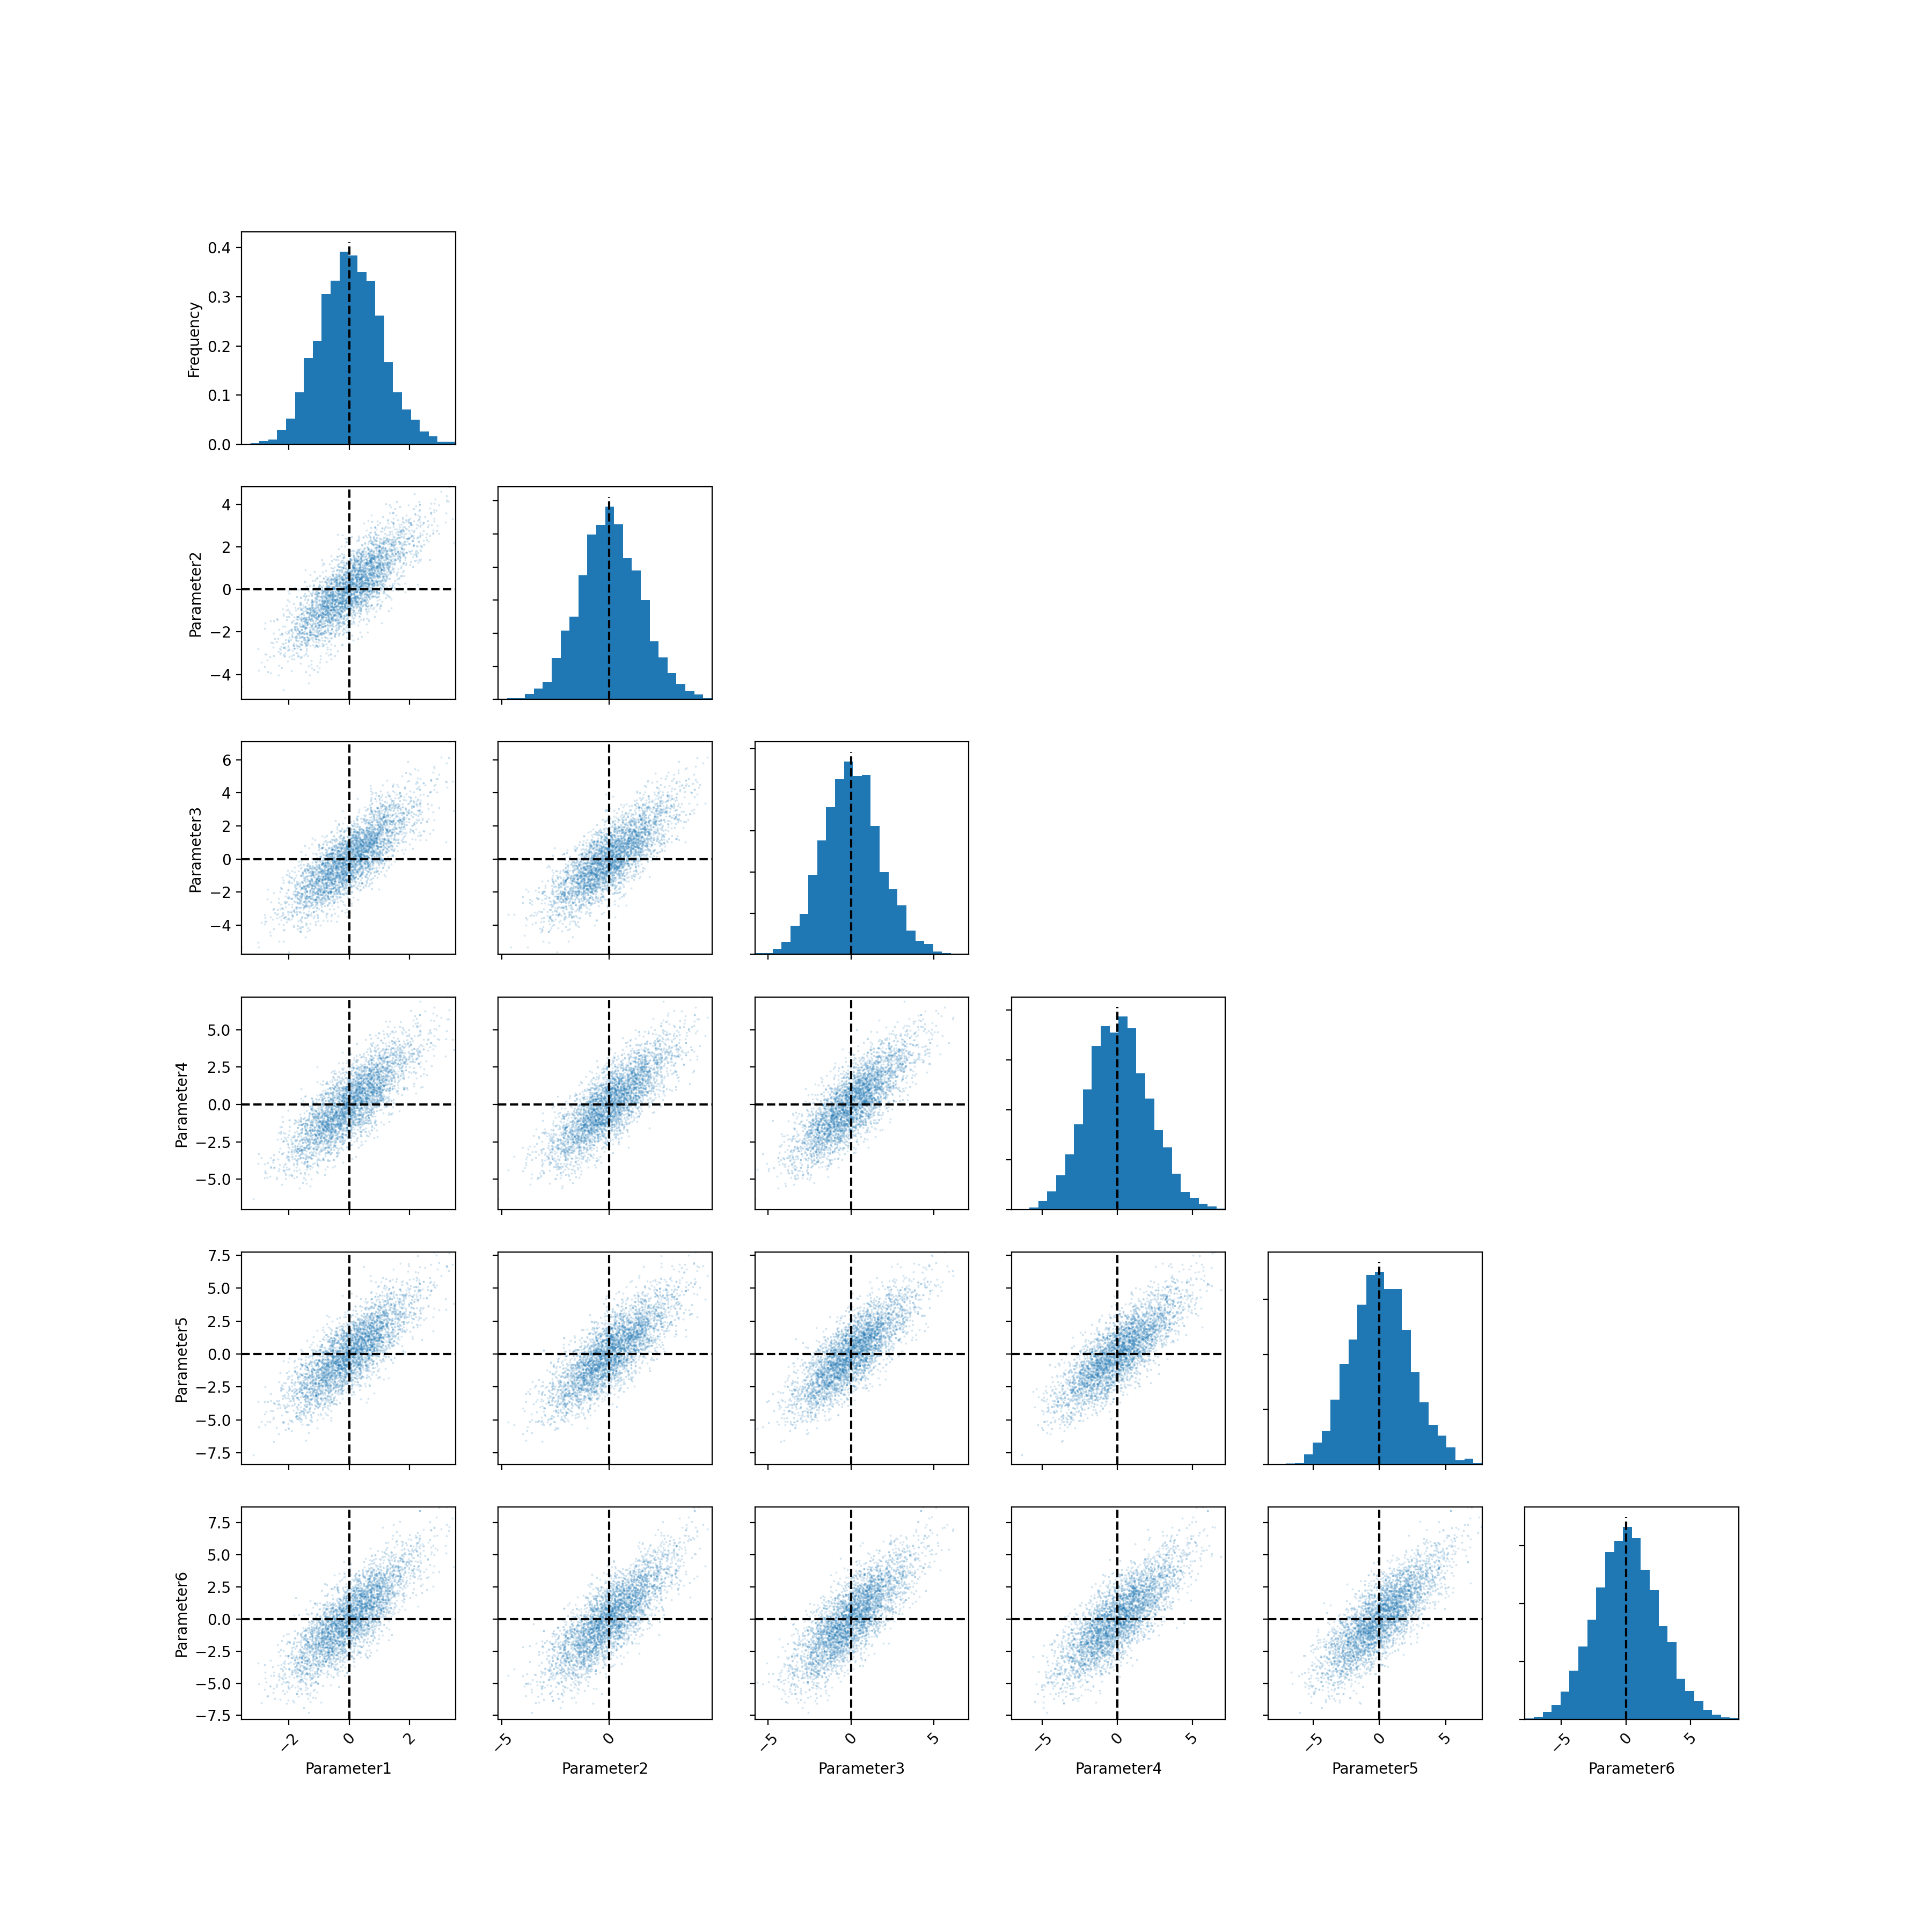

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  0.05    1.02    -1.87   -0.66  0.03   0.73   2.14     1.01    486.51  81.86
param 2  0.07    1.43    -2.66   -0.89  0.04   1.03   2.96     1.01    471.56  79.34
param 3  0.07    1.75    -3.32   -1.12  0.03   1.18   3.66     1.01    487.05  81.95
param 4  0.10    2.03    -3.74   -1.32  0.07   1.44   4.14     1.01    484.82  81.57
param 5  0.11    2.26    -4.18   -1.44  0.09   1.59   4.71     1.01    490.04  82.45
param 6  0.11    2.47    -4.56   -1.54  0.08   1.77   5.08     1.01    475.60  80.02


In [8]:
n_chains = 4
n_iterations = 2000
n_warmup = 1000

log_pdf = pints.toy.HighDimensionalGaussianLogPDF(dimension=6, rho=0.8)
x0 = np.random.uniform(-4, 4, size=(n_chains, 6))
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.NoUTurnMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.pairwise(np.vstack(chains), kde=False, ref_parameters=([0] * 6))

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

Again the estimated means compare well with the theoretical. Now comparing the theoretical and empirical cdfs: again, these look fine.

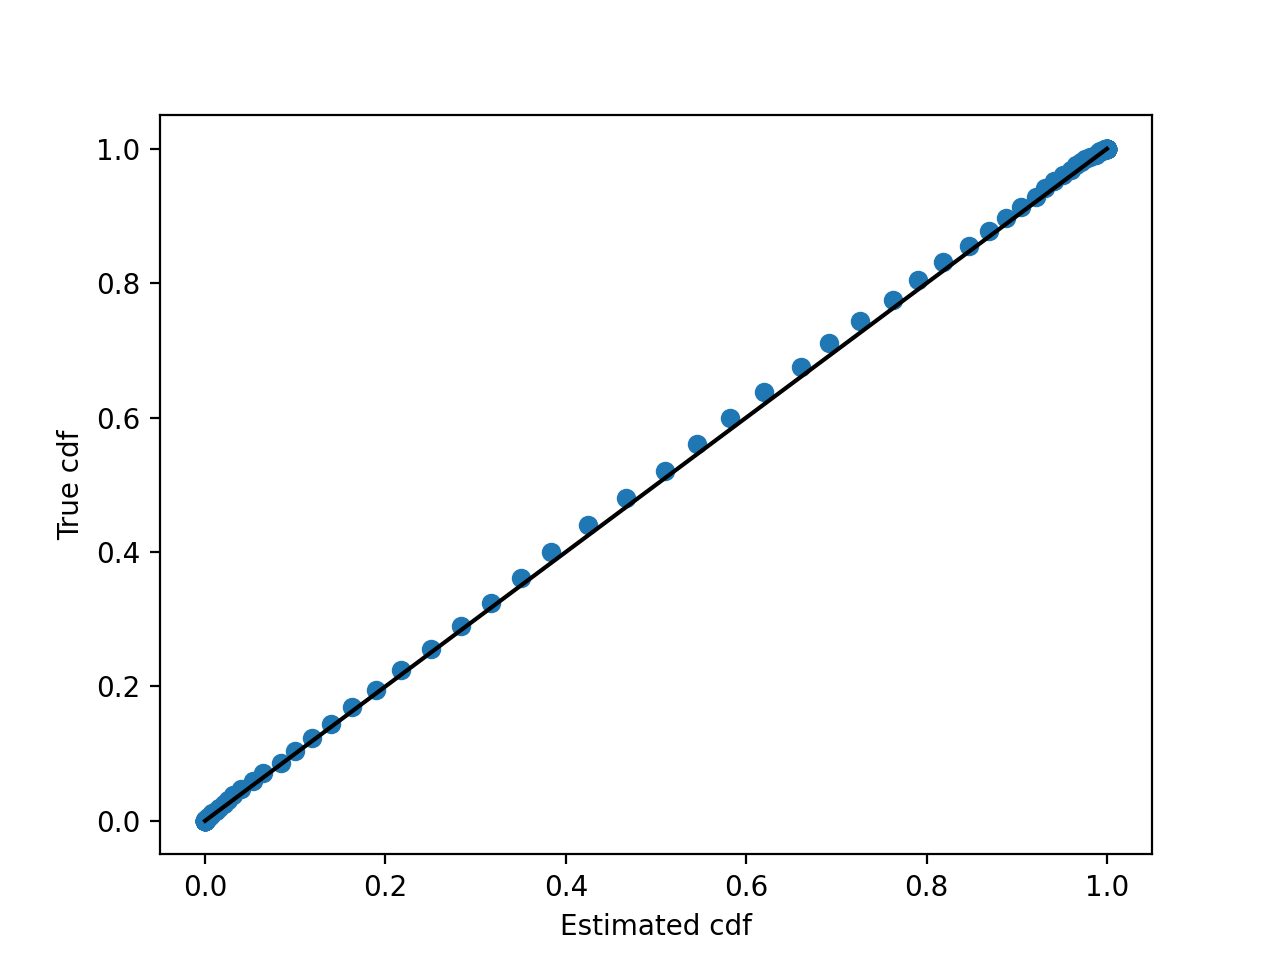

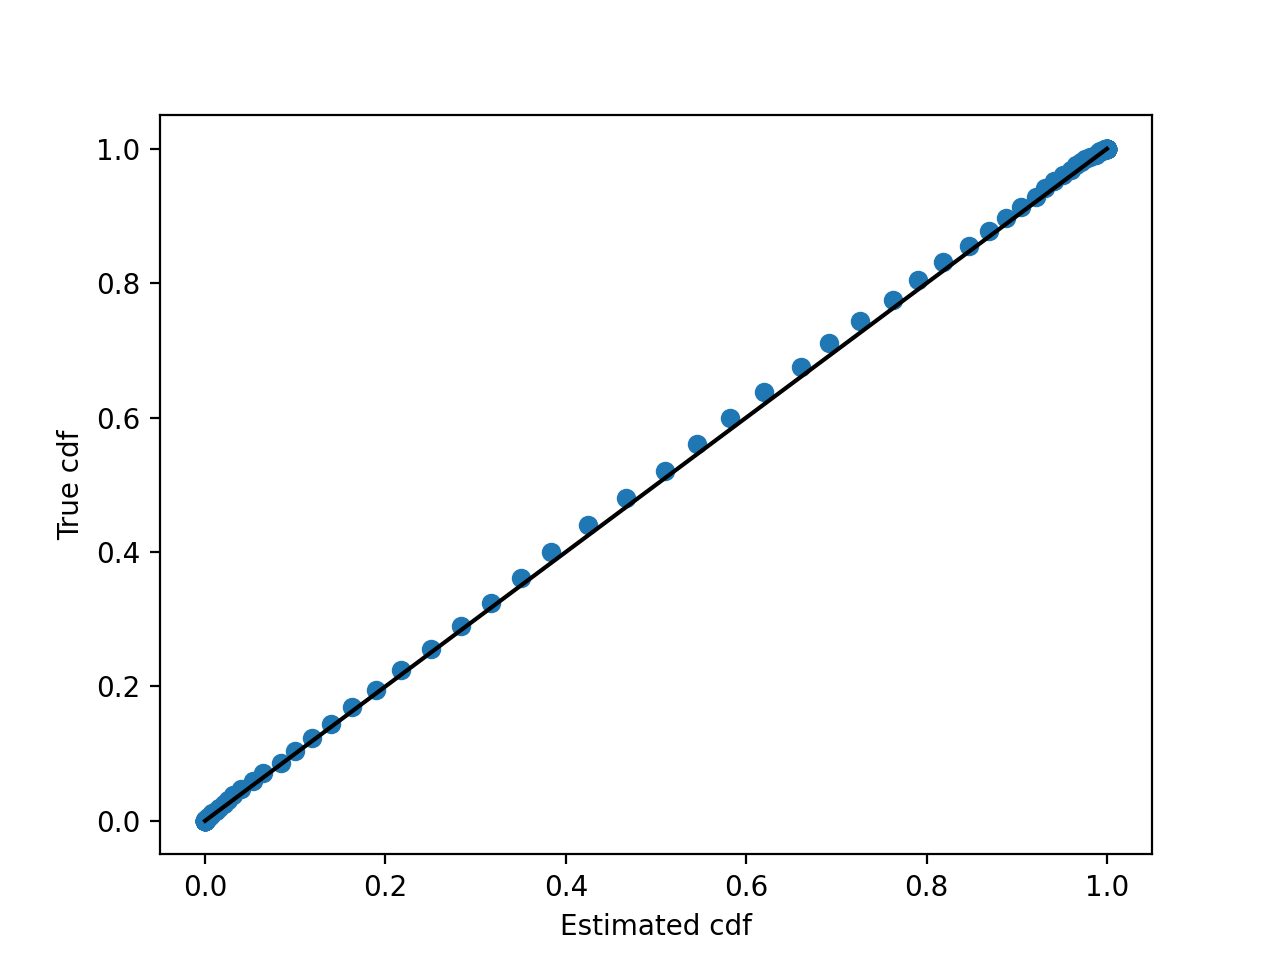

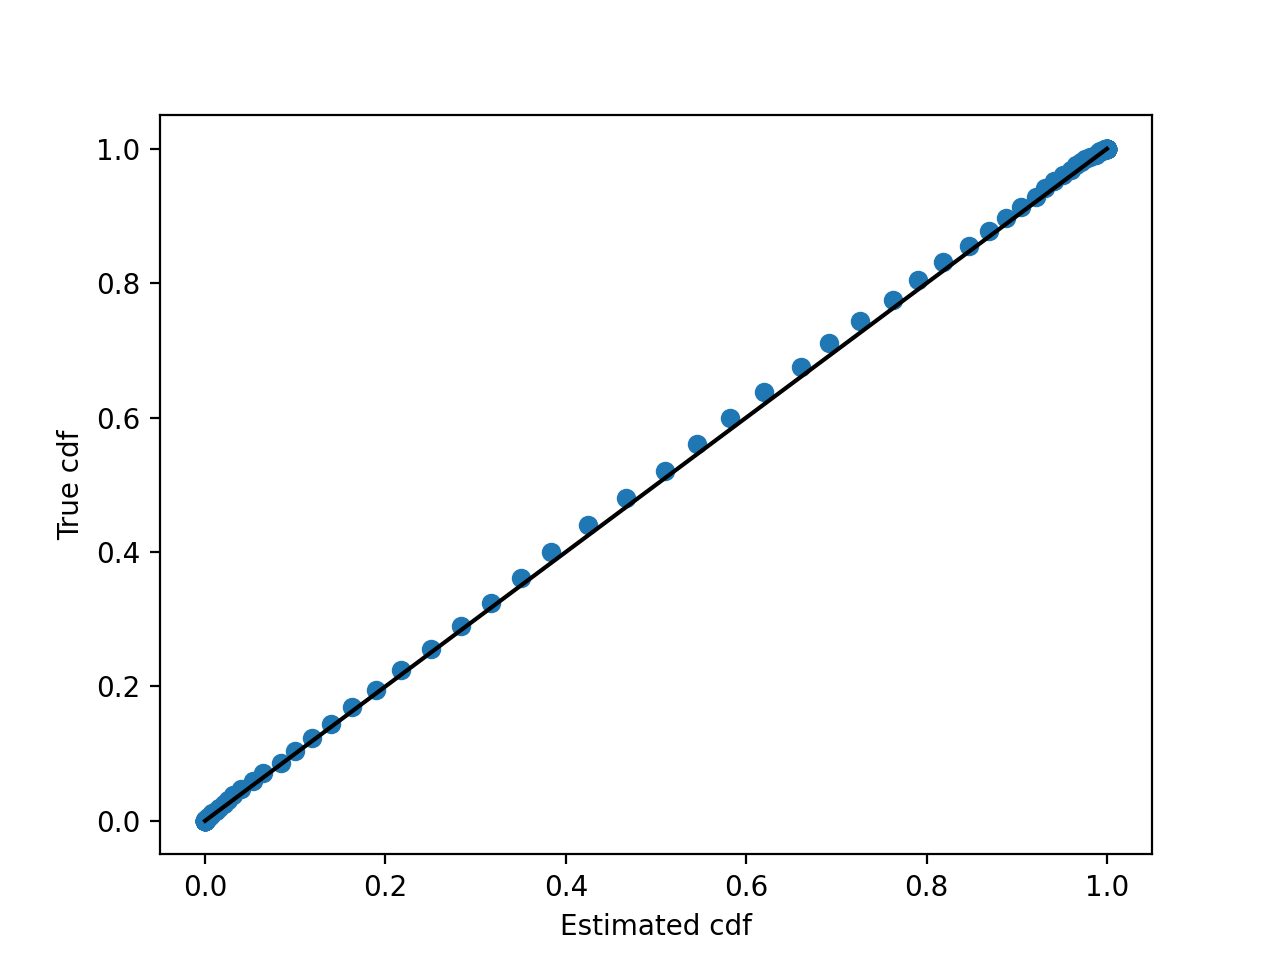

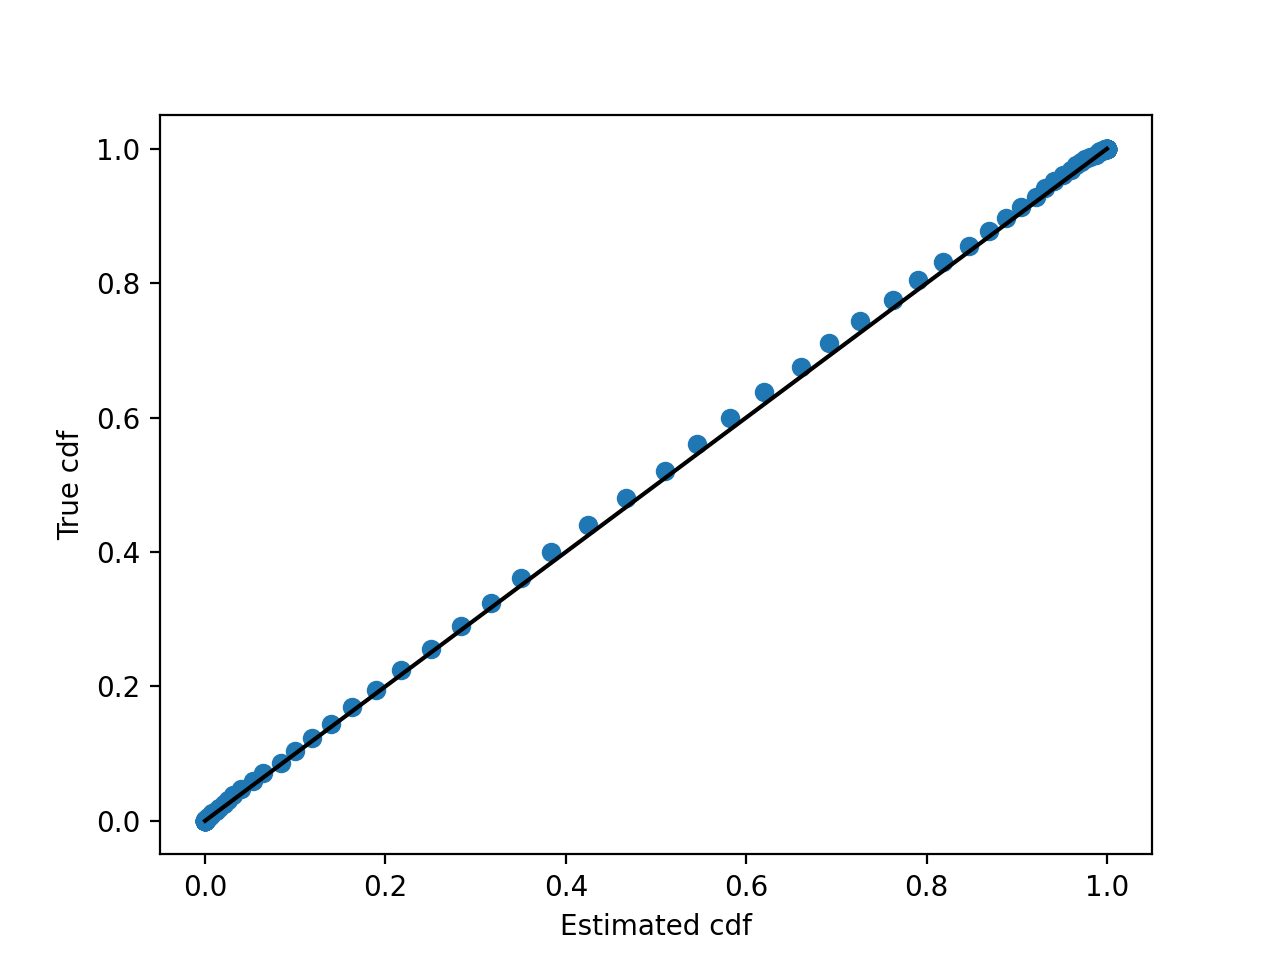

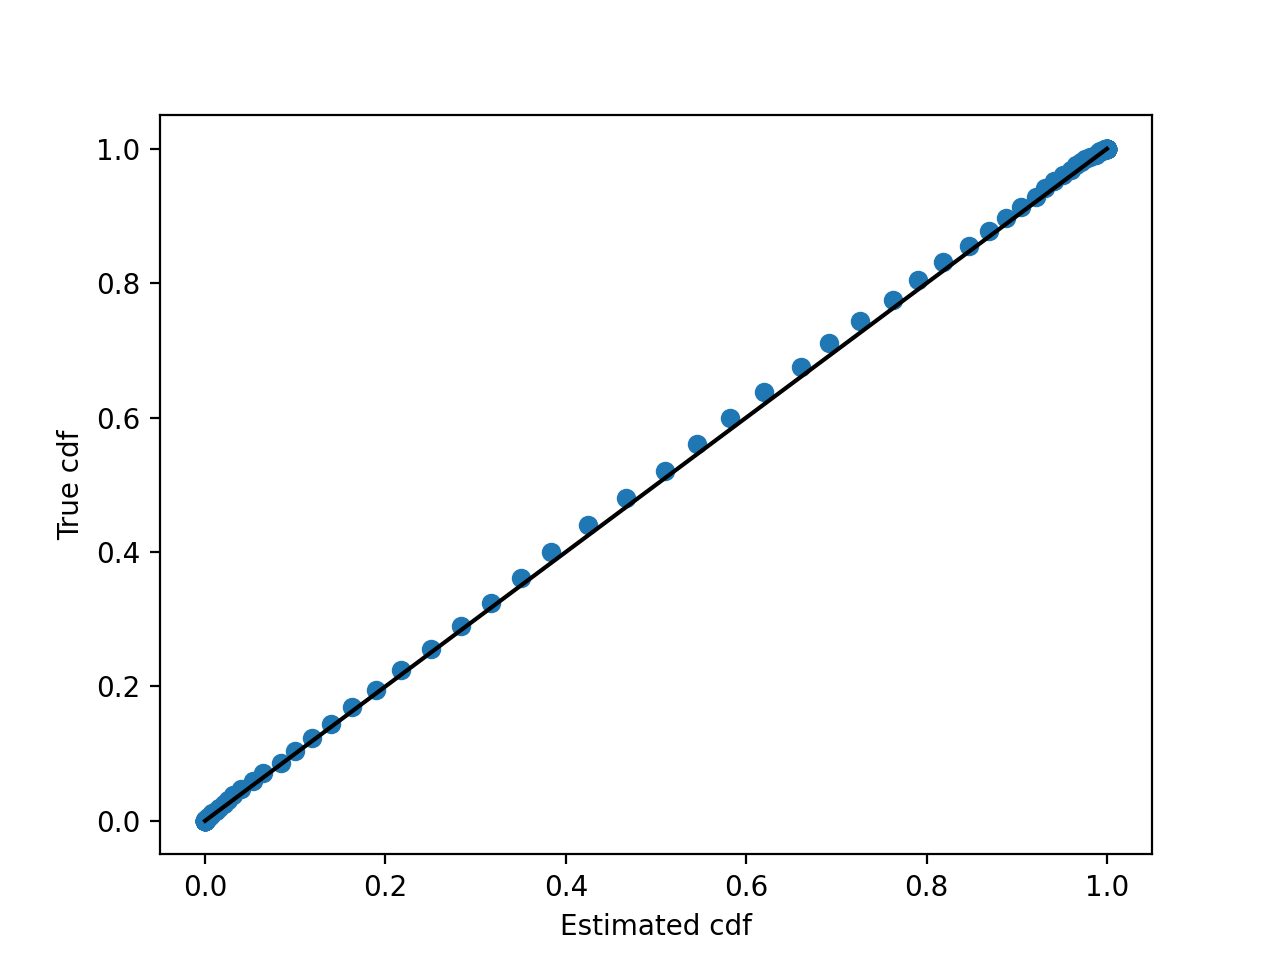

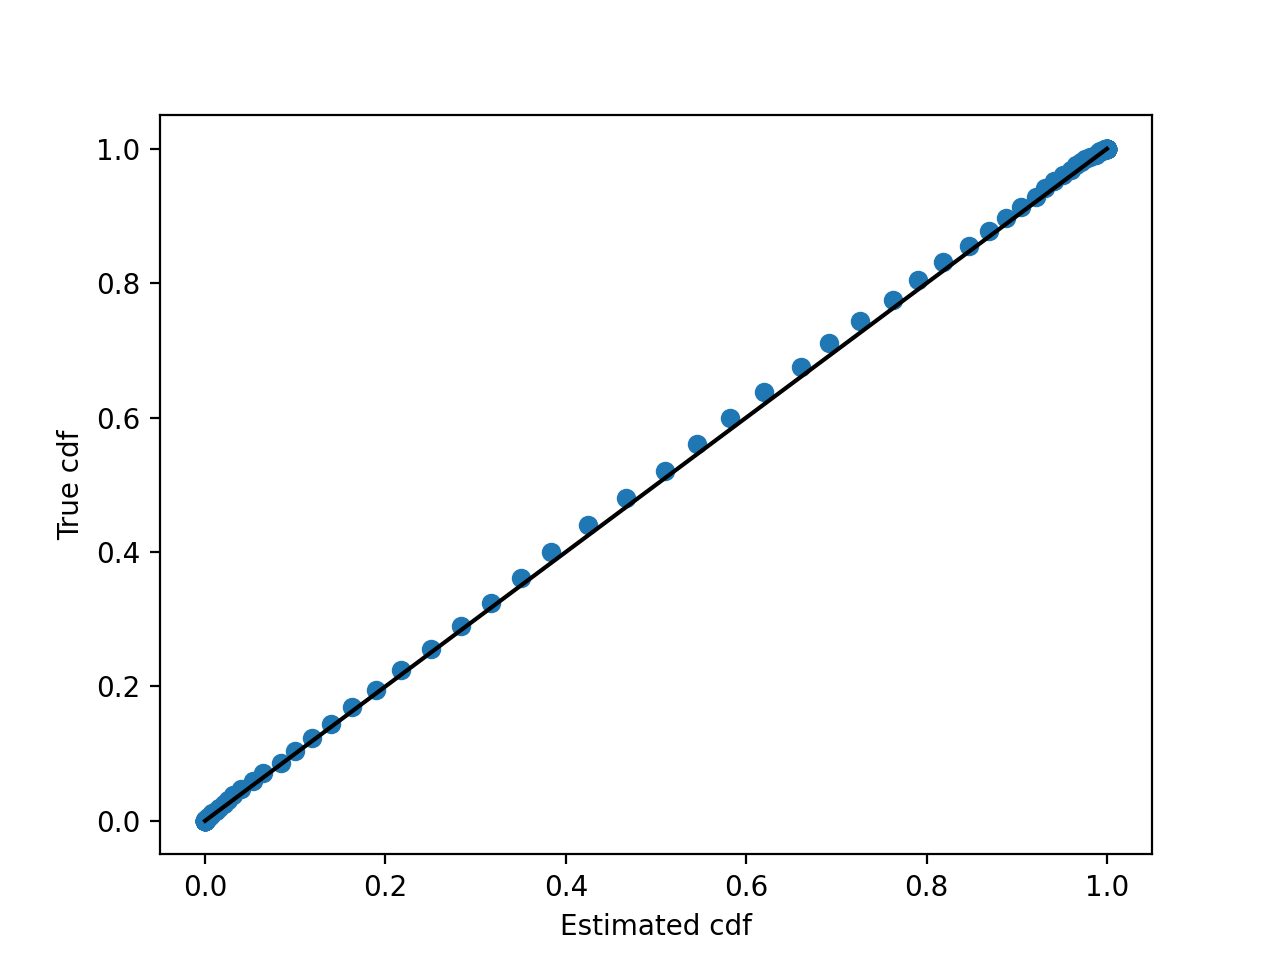

In [9]:
draws = np.vstack(chains)
for _ in range(6):
    ecdf_norm_plotter(draws[:, 0], np.sqrt(1))

# Annulus

In [10]:
t = pints.Timer()
test = run_replicates(np.geomspace(1000, 5000, 8), 10, nuts.annulus, parallel)
print(t.format())

df = pd.melt(test, id_vars=['iterations', 'replicate'])
#df.to_csv("experimental_data/no_u_turn_annulus.csv")

10 minutes, 56 seconds


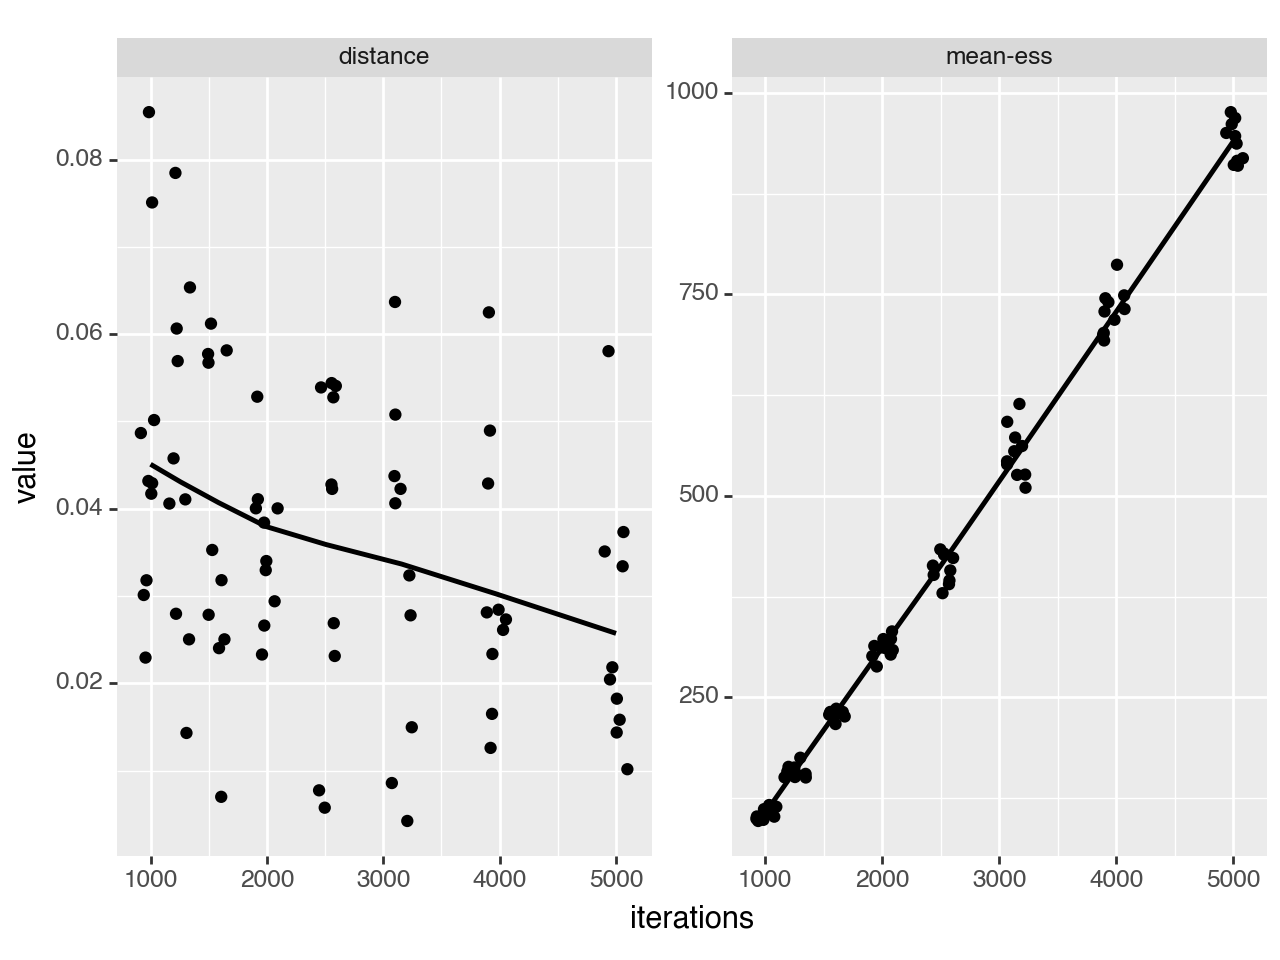

<Figure Size: (640 x 480)>

In [11]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
)

The draws trend closer to convergence as the number of iterations increases, although the effective sample size is low here.

Example run.

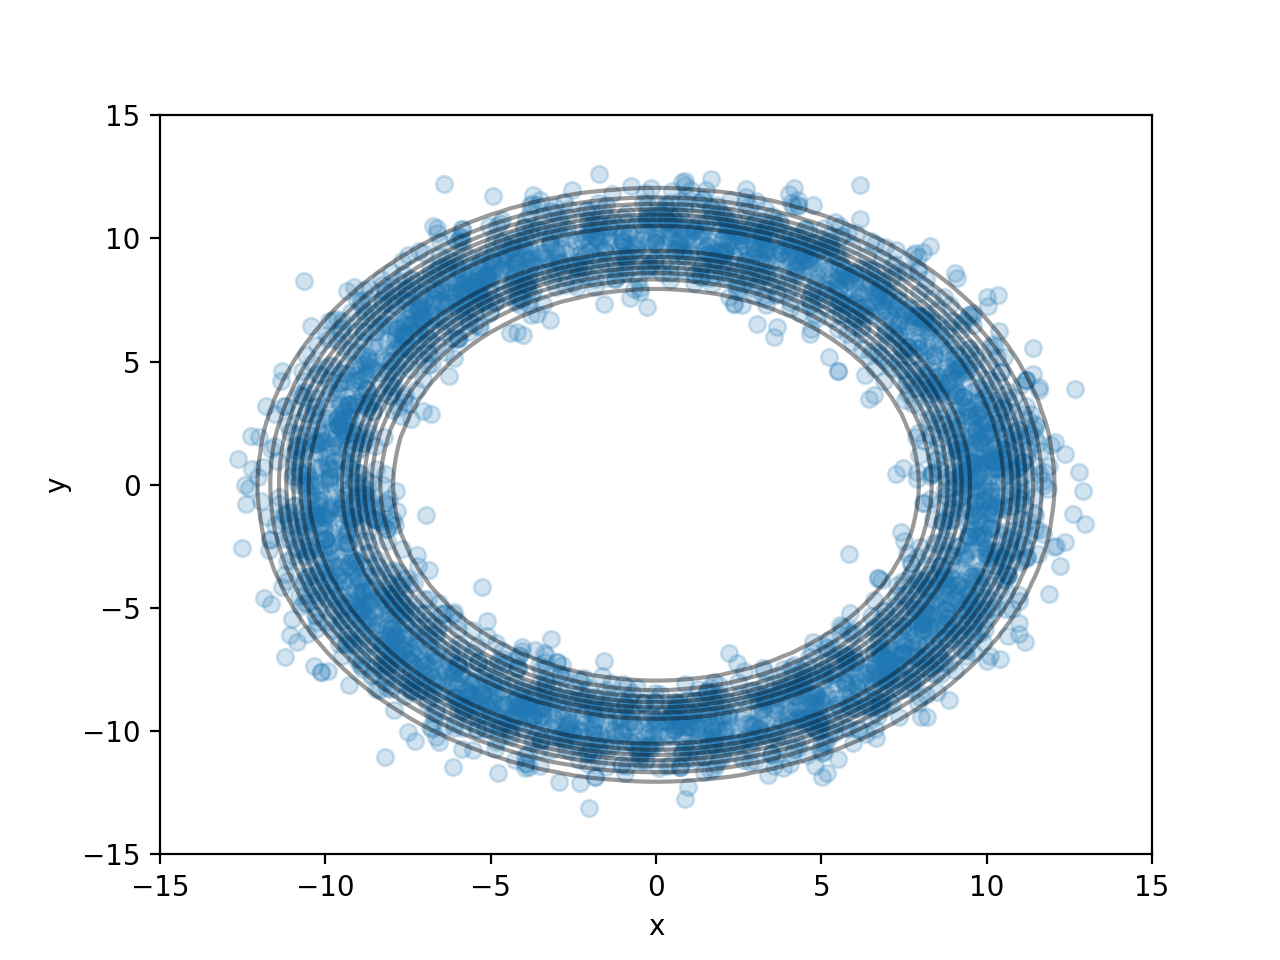

In [12]:
n_chains = 4
n_iterations = 2000
n_warmup = 1000

log_pdf = pints.toy.AnnulusLogPDF()
x0 = log_pdf.sample(n_chains)

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.NoUTurnMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = np.vstack(chains[:, n_warmup:])

num_points = 100
x = np.linspace(-15, 15, num_points)
y = np.linspace(-15, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z, colors='k', alpha=0.4)
plt.scatter(chains[:, 0], chains[:, 1], alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# High dimensional Gaussian

In [13]:
t = pints.Timer()
test = run_replicates(np.geomspace(1000, 5000, 8), 10, nuts.high_dim_gaussian, parallel)
print(t.format())

df = pd.melt(test, id_vars=['iterations', 'replicate'])
#df.to_csv("experimental_data/no_u_turn_high_dim_gaussian.csv")

2 minutes, 54 seconds


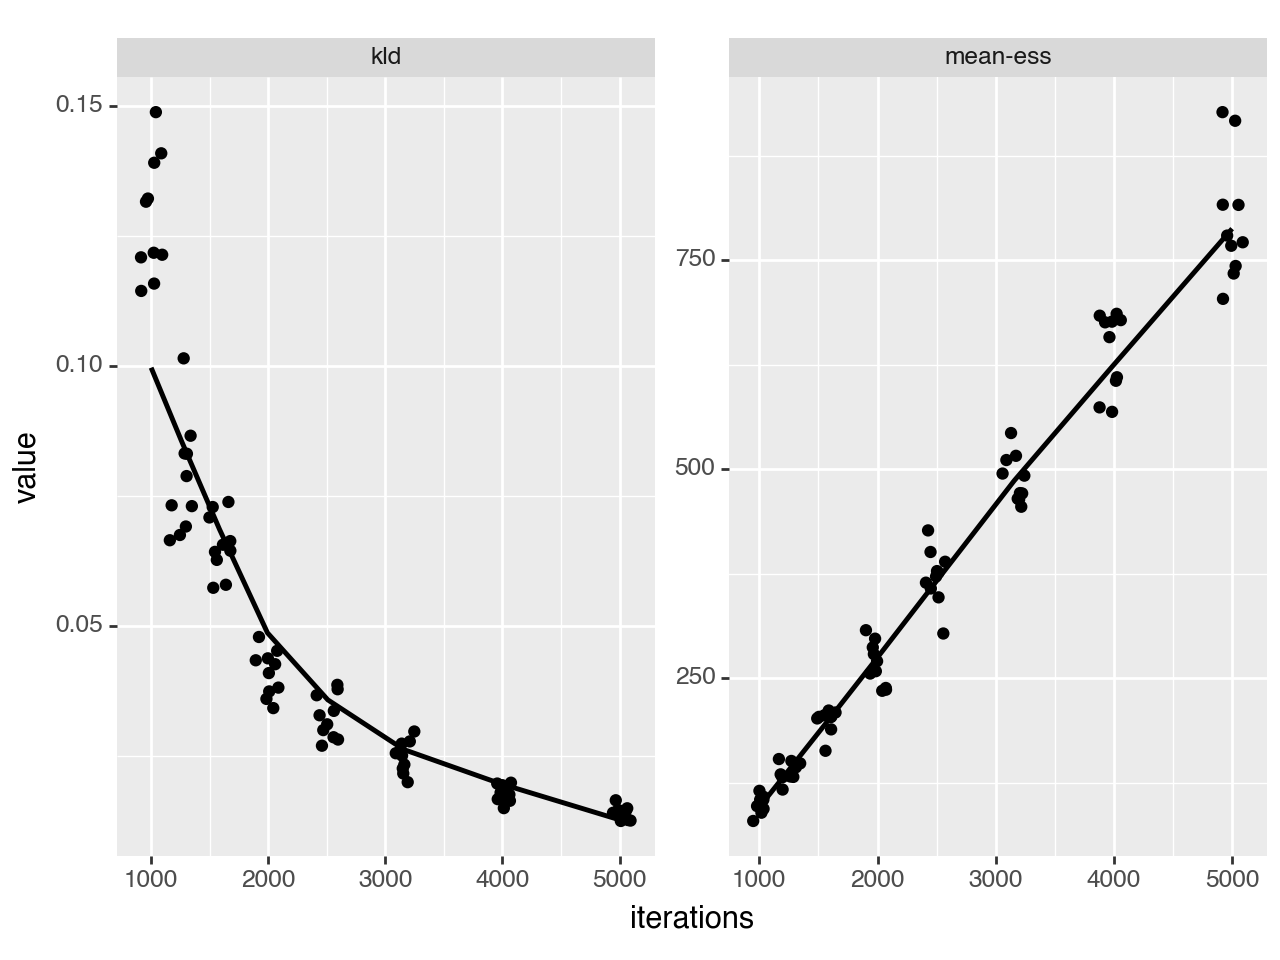

<Figure Size: (640 x 480)>

In [14]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
)

Example run of results.

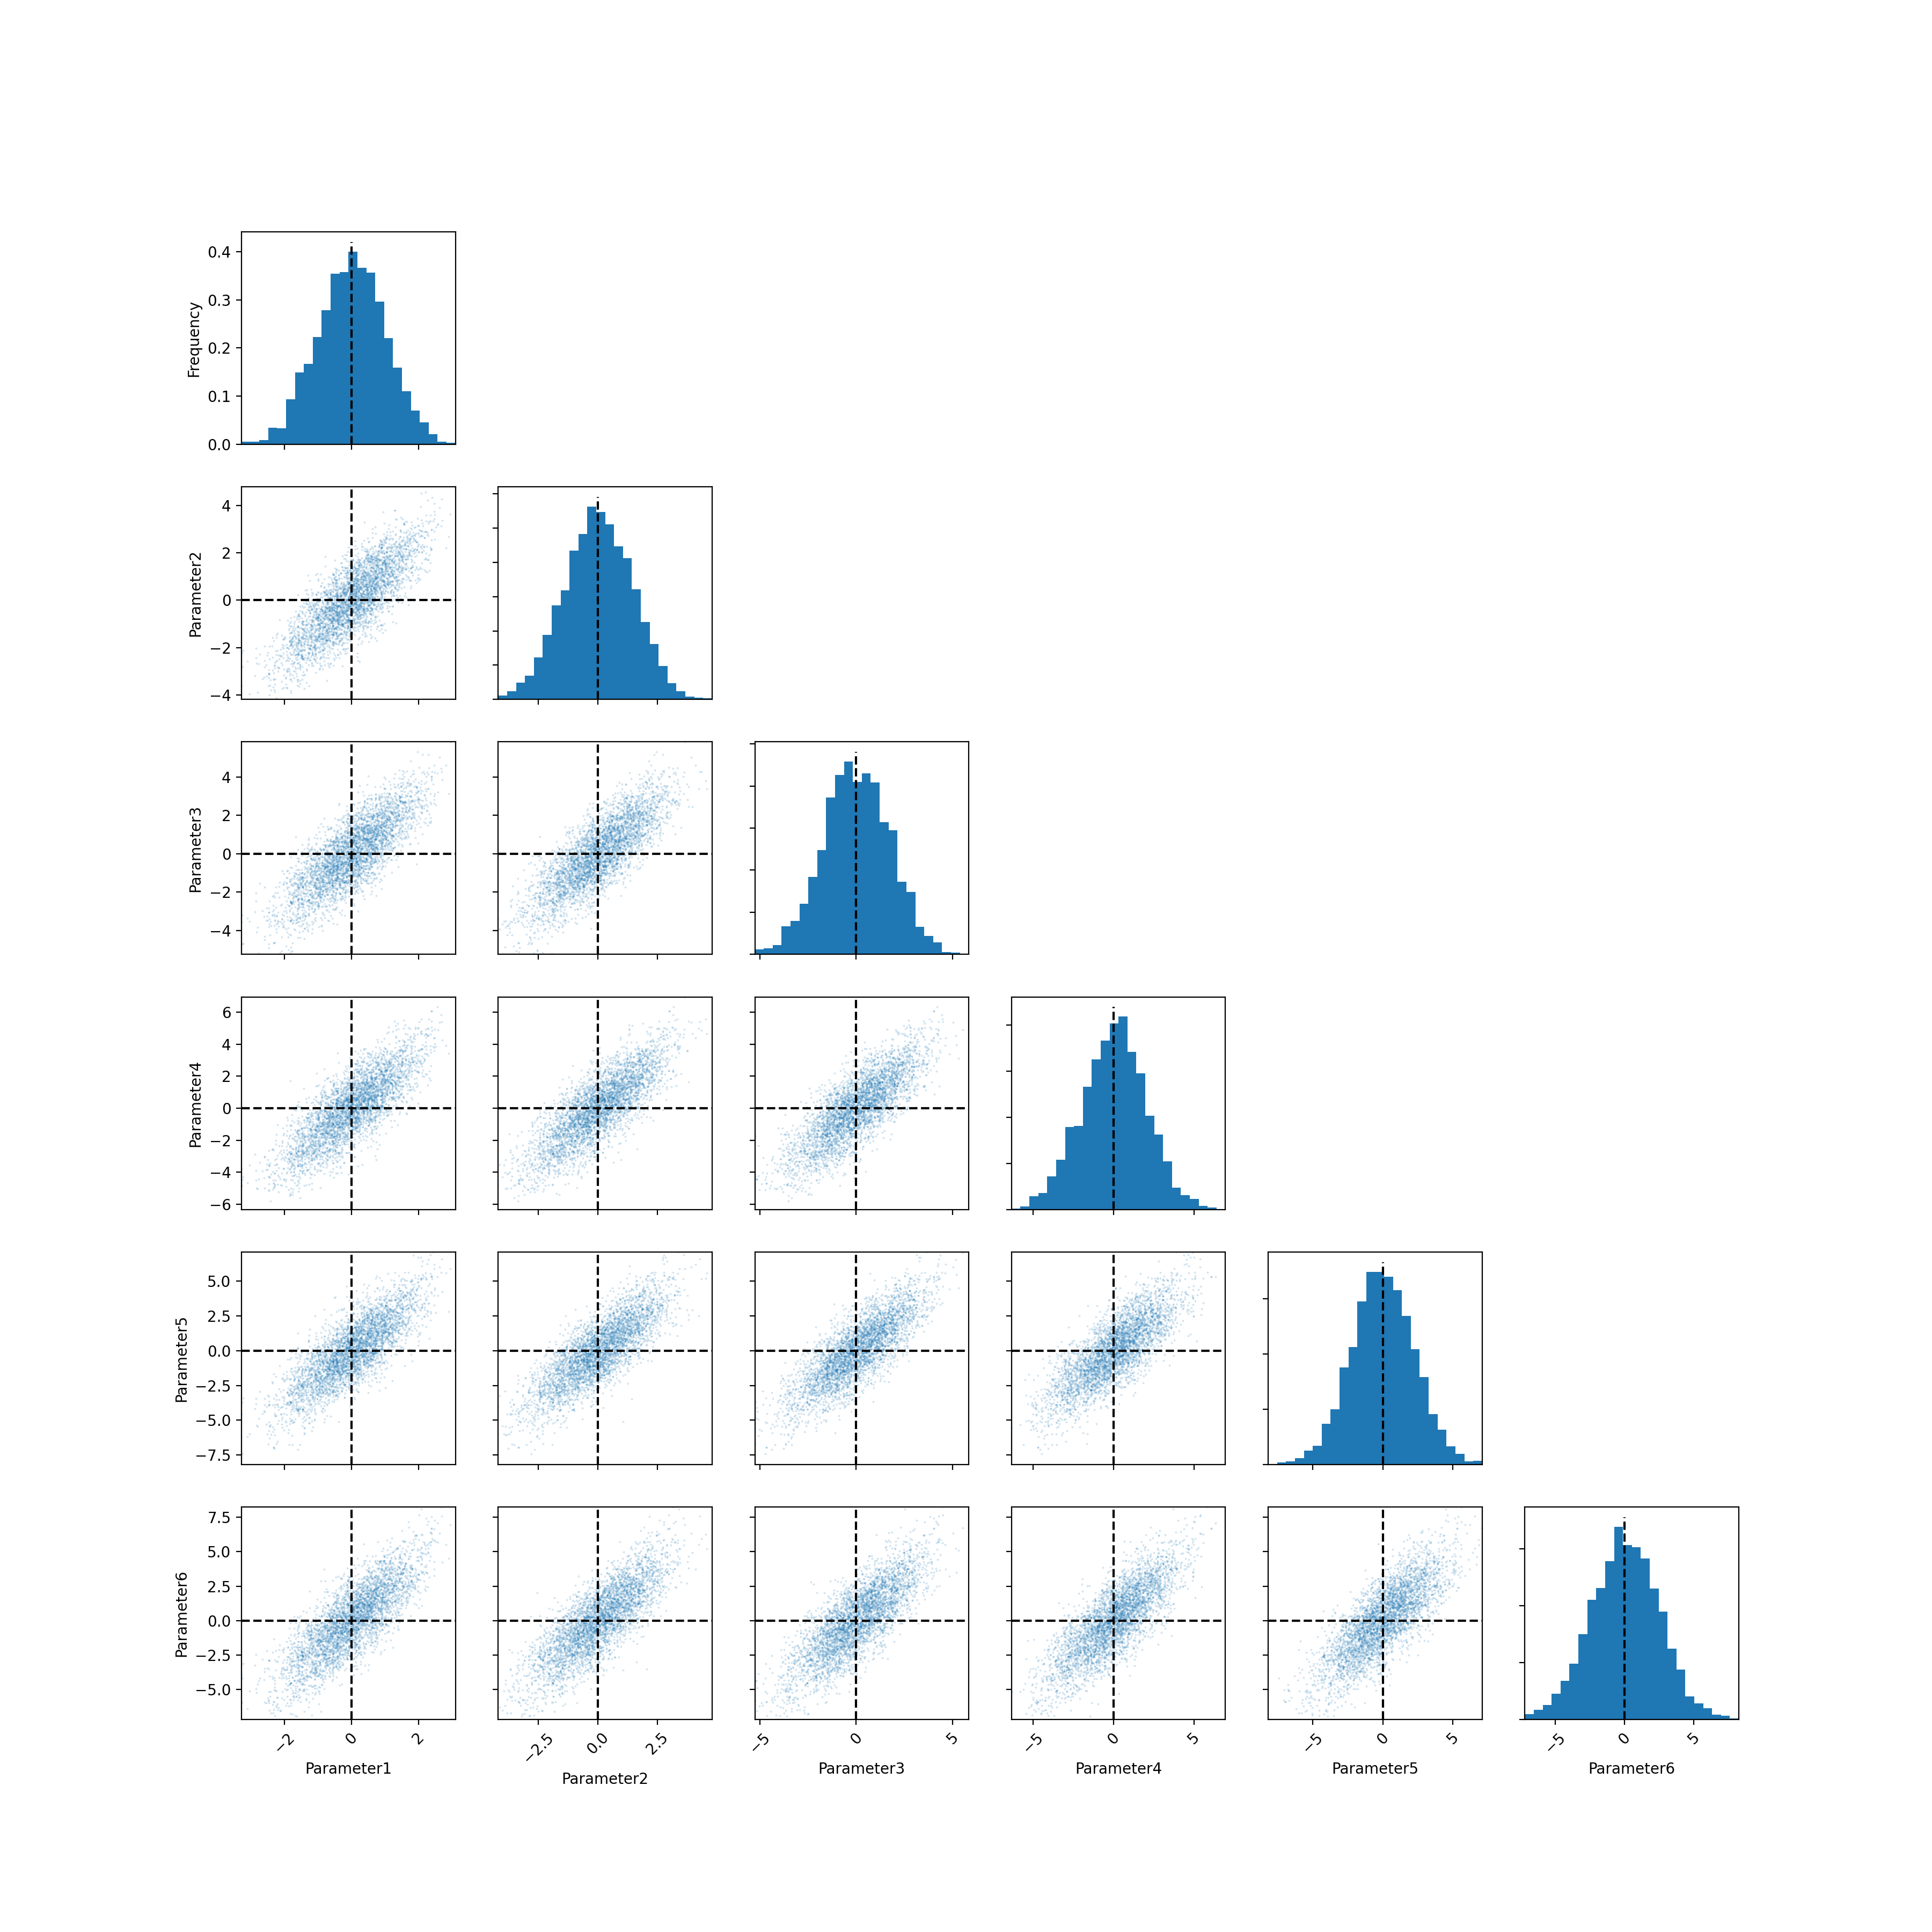

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  0.01    1.00    -1.92   -0.67  0.03   0.70   1.95     1.00    505.47  117.06
param 2  0.02    1.42    -2.77   -0.94  0.02   1.01   2.70     1.00    518.51  120.08
param 3  0.03    1.72    -3.46   -1.12  0.02   1.21   3.28     1.00    524.12  121.38
param 4  0.03    2.00    -3.97   -1.30  0.08   1.38   3.84     1.00    510.53  118.23
param 5  0.00    2.24    -4.37   -1.49  -0.03  1.52   4.34     1.00    495.83  114.83
param 6  0.05    2.45    -4.91   -1.59  0.08   1.73   4.80     1.00    534.94  123.88


In [15]:
n_chains = 4
n_iterations = 2000
n_warmup = 1000

log_pdf = pints.toy.HighDimensionalGaussianLogPDF(dimension=6, rho=0.8)
x0 = np.random.uniform(-4, 4, size=(n_chains, 6))
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.NoUTurnMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.pairwise(np.vstack(chains), kde=False, ref_parameters=([0] * 6))

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

Again the estimated means compare well with the theoretical. Now comparing the theoretical and empirical cdfs: again, these look fine.

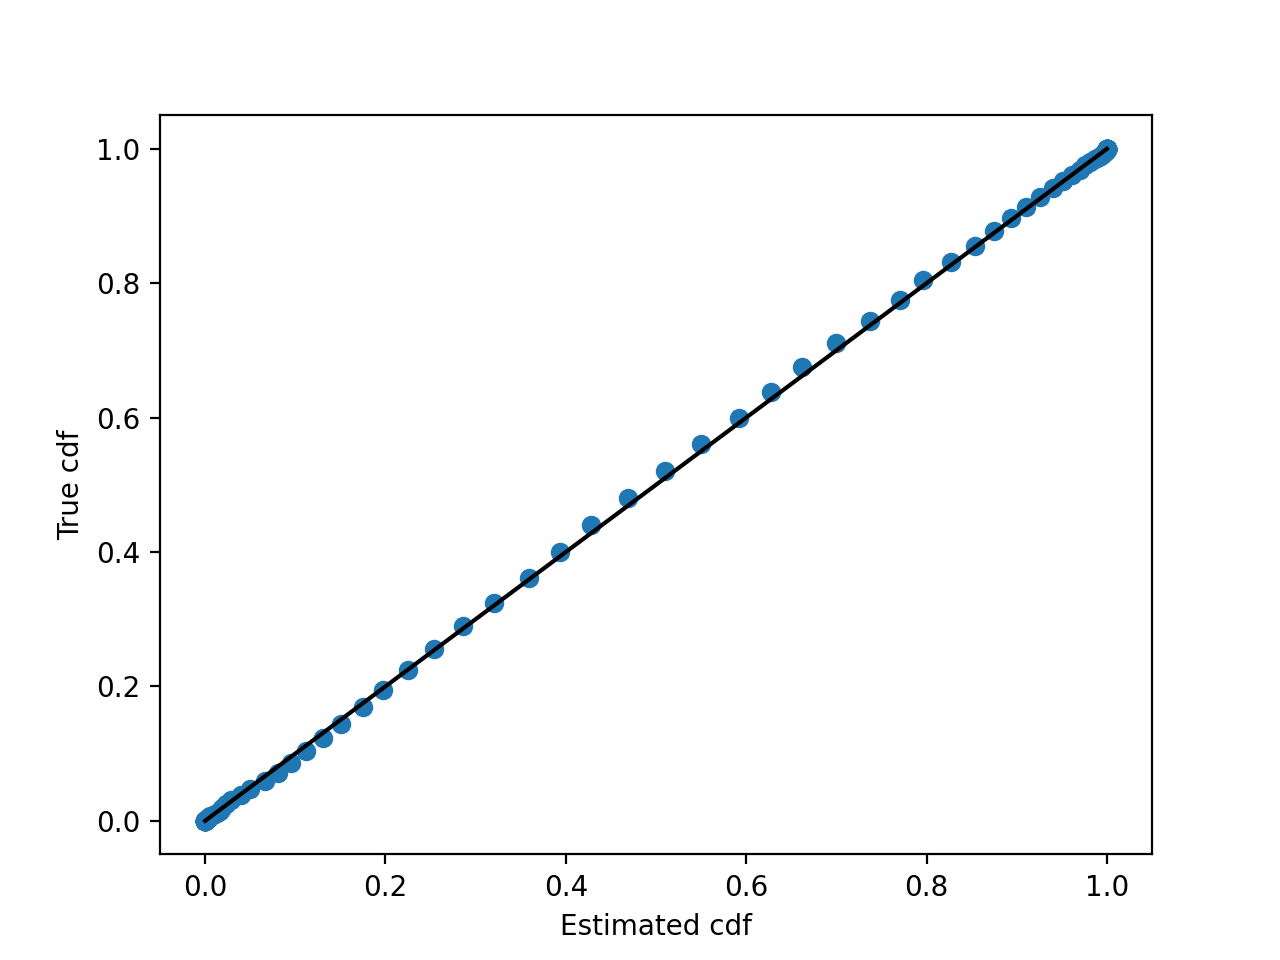

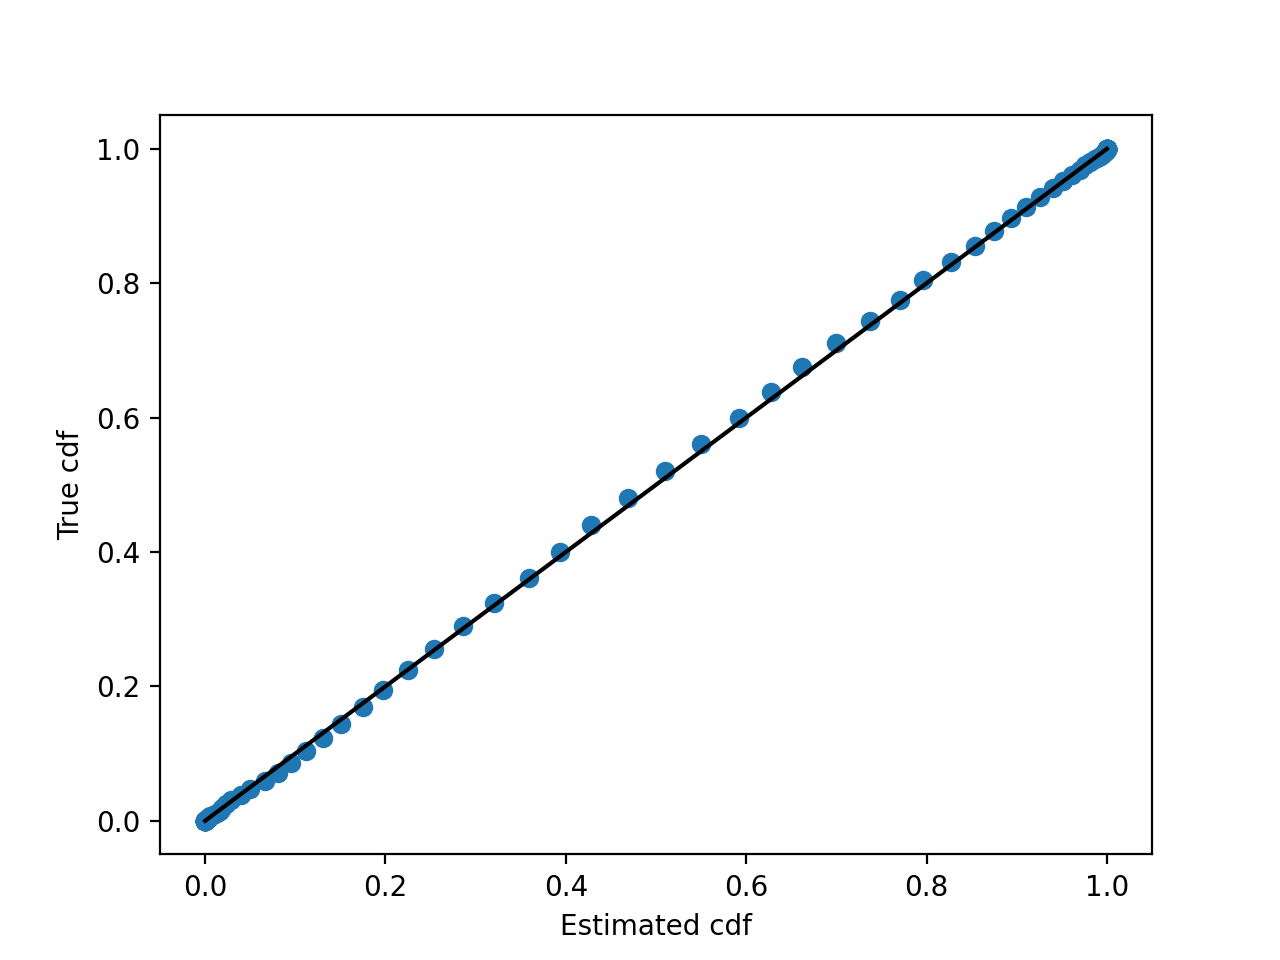

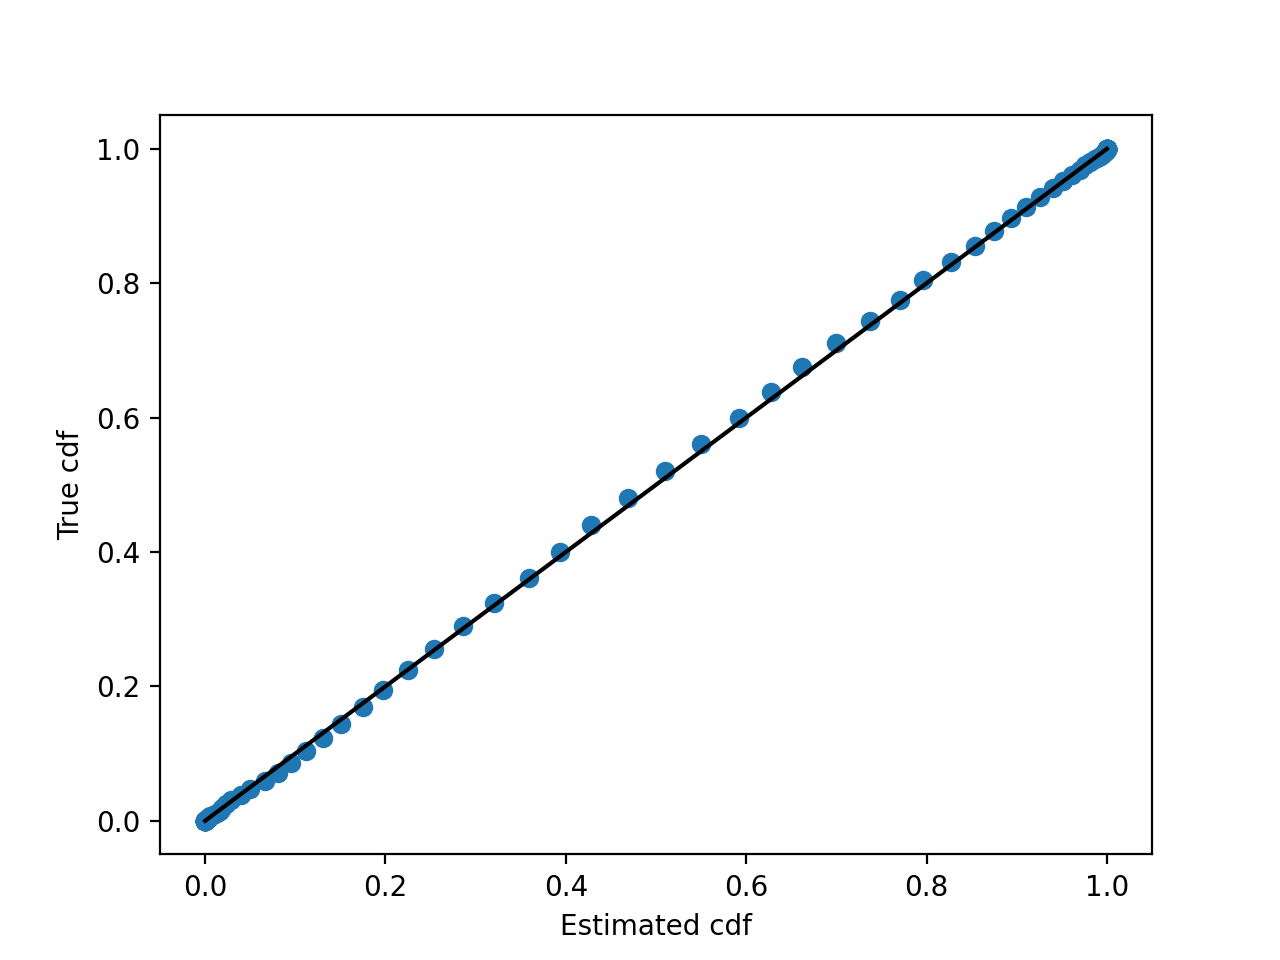

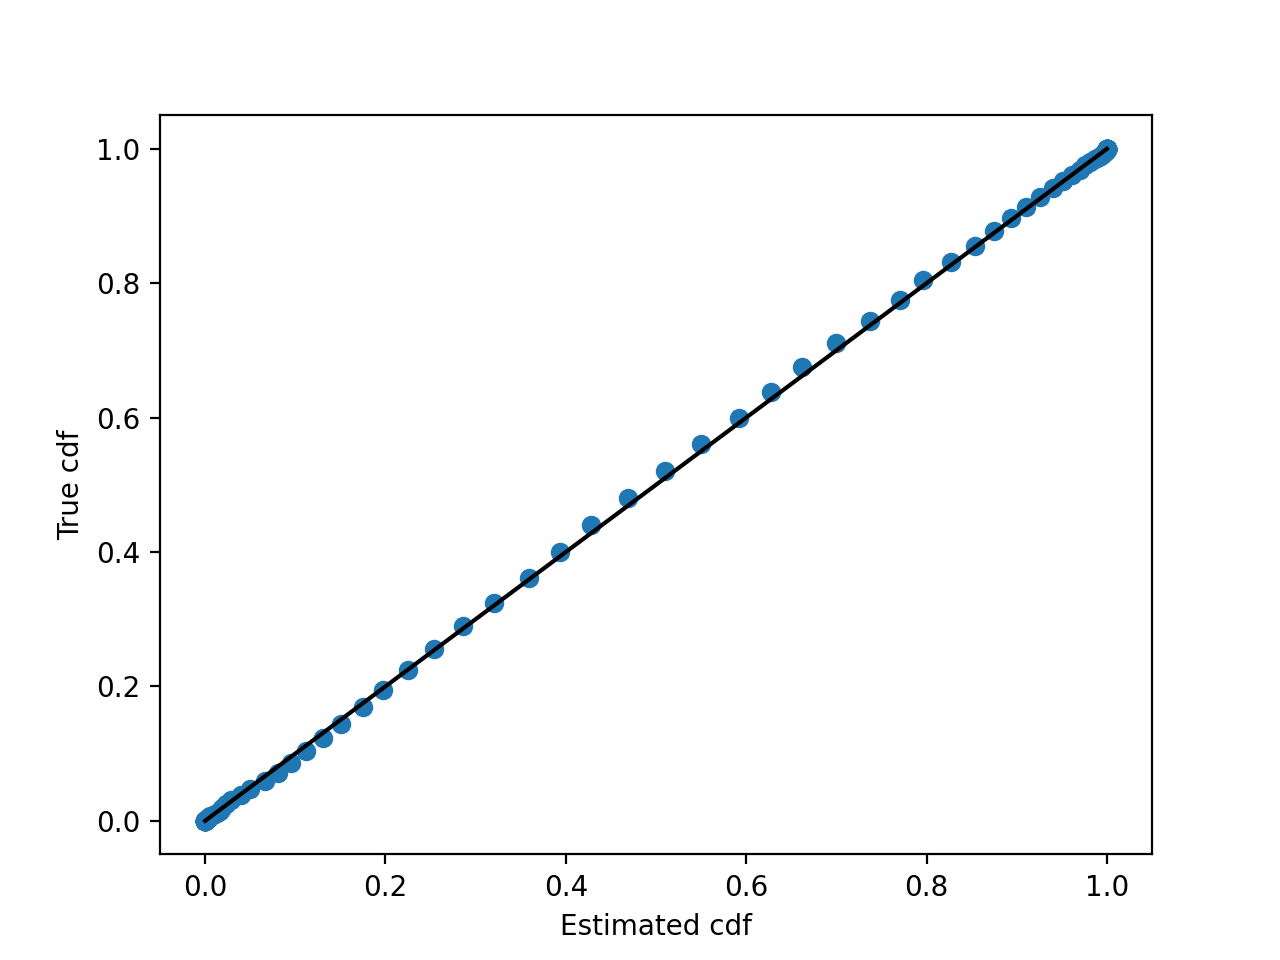

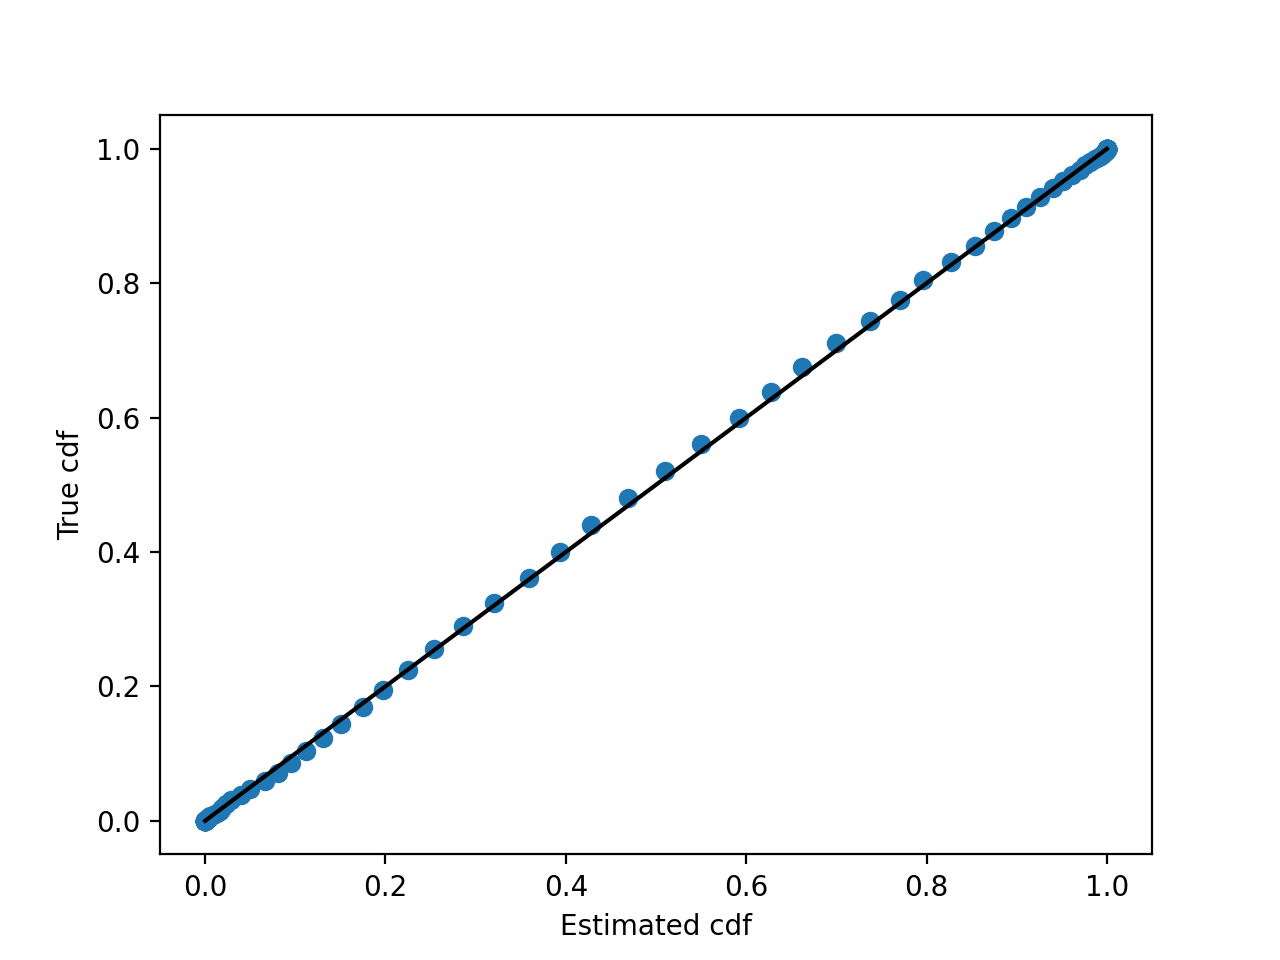

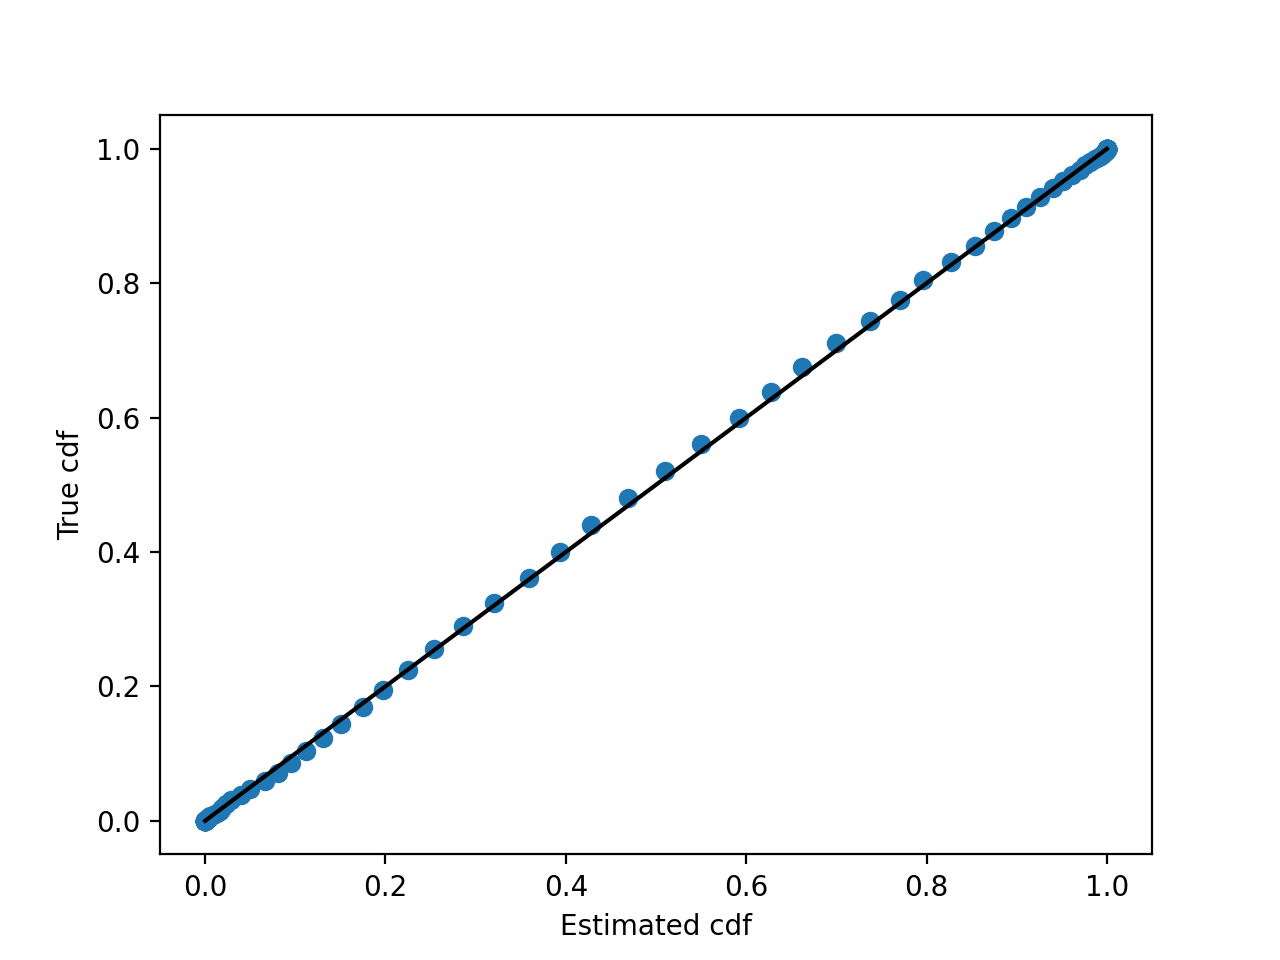

In [16]:
draws = np.vstack(chains)
for _ in range(6):
    ecdf_norm_plotter(draws[:, 0], np.sqrt(1))